States (S): The set of all non-obstacle cells (x, y, z) within the 6×6×6 grid. The total state space size is 63−N_obstacles.

Actions (A): A set of 6 actions: {0: '+x (East)', 1: '-x (West)', 2: '+y (North)', 3: '-y (South)', 4: '+z (Up)', 5: '-z (Down)}. We map them to indices for convenience.

Transitions (P): The transition model is stochastic. When the agent chooses an action, it moves in the intended direction with probability p. With probability 

1-p, it "slips" and moves to one of the 4 perpendicular directions, each with a probability of (1-p)/4. If a move would result in hitting a boundary or an obstacle, the agent stays in its current state.

Rewards (R): The agent receives a reward based on its transition:

+50 for entering the goal state (absorbing).

-50 for entering a pit state (absorbing).

-1 (step cost) for all other moves.

Discount (γ): The discount factor is set to 0.95, valuing immediate rewards slightly more than future ones.

In [2]:
# Part B: Environment Implementation (Setup)
# ---
# Import necessary libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm  # A handy library for progress bars

# For reproducibility of obstacle placement
random.seed(42) # [cite: 54]
np.random.seed(42)

In [3]:
# Part B: Environment Implementation [cite: 35]
class Gridworld3D:
    def __init__(self, size=6, slip_prob=0.2, step_cost=-1):
        self.size = size
        self.slip_prob = slip_prob
        self.p = 1 - self.slip_prob # Probability of intended move
        self.step_cost = step_cost

        # Define the state space, actions, and terminals
        self.start_pos = (0, 0, 0)
        self.goal_pos = (5, 5, 5) # [cite: 21]
        self.pit_pos = (2, 2, 2)   # [cite: 21]
        self.terminals = [self.goal_pos, self.pit_pos]

        # Generate obstacles (~10-15% of cells) [cite: 22]
        self.obstacles = self._place_obstacles(num_obstacles=30)

        # Actions: 0:E, 1:W, 2:N, 3:S, 4:U, 5:D
        self.actions = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
        self.reset()

    def _place_obstacles(self, num_obstacles):
        obstacles = set()
        while len(obstacles) < num_obstacles:
            pos = tuple(np.random.randint(0, self.size, size=3))
            # Ensure obstacles don't block start, goal, or pit [cite: 22]
            if pos not in [self.start_pos, self.goal_pos, self.pit_pos]:
                obstacles.add(pos)
        return list(obstacles)

    def reset(self):
        self.state = self.start_pos
        return self.state

    def step(self, action_idx):
        if self.state in self.terminals:
            return self.state, 0, True # Episode is done

        # Determine the actual move based on slip probability
        if np.random.rand() < self.p:
            # Intended move
            move = self.actions[action_idx]
        else:
            # Slip! Choose a perpendicular direction
            perpendicular_actions = self._get_perpendicular(action_idx)
            move = self.actions[random.choice(perpendicular_actions)]

        # Calculate next state
        next_state = (self.state[0] + move[0],
                      self.state[1] + move[1],
                      self.state[2] + move[2])

        # Check boundaries and obstacles
        if not self._is_valid(next_state):
            next_state = self.state # Stay in place if move is invalid

        # Determine reward and if the episode is done
        done = False
        if next_state == self.goal_pos:
            reward = 50
            done = True
        elif next_state == self.pit_pos:
            reward = -50
            done = True
        else:
            reward = self.step_cost

        self.state = next_state
        return self.state, reward, done

    def _get_perpendicular(self, action_idx):
        # Maps an action axis to its perpendicular axes
        # x-axis (0,1) -> y,z axes (2,3,4,5)
        # y-axis (2,3) -> x,z axes (0,1,4,5)
        # z-axis (4,5) -> x,y axes (0,1,2,3)
        if action_idx in [0, 1]: return [2, 3, 4, 5]
        if action_idx in [2, 3]: return [0, 1, 4, 5]
        if action_idx in [4, 5]: return [0, 1, 2, 3]

    def _is_valid(self, state):
        x, y, z = state
        if not (0 <= x < self.size and 0 <= y < self.size and 0 <= z < self.size):
            return False # Out of bounds
        if state in self.obstacles:
            return False # Hit an obstacle
        return True

# Create an instance of the environment
env = Gridworld3D()
print(f"Grid Size: {env.size}x{env.size}x{env.size}")
print(f"Number of Obstacles: {len(env.obstacles)}")

Grid Size: 6x6x6
Number of Obstacles: 30


In [4]:
# Part C: Q-learning Implementation [cite: 37]

# --- Hyperparameters ---
EPISODES = 5000
ALPHA = 0.1  # Learning rate
GAMMA = 0.95 # Discount factor 
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.9995

# --- Initialization ---
# Q-table: Use a dictionary for sparse storage {state: np.array(q_values_for_actions)}
q_table = {}
# Get all possible states (non-obstacle cells)
all_states = [
    (x, y, z) for x in range(env.size) for y in range(env.size) for z in range(env.size)
    if (x, y, z) not in env.obstacles
]
# Initialize Q-values to zero for all state-action pairs
for state in all_states:
    q_table[state] = np.zeros(len(env.actions))

episode_rewards = []
epsilon = EPSILON_START

# --- Training Loop ---
for episode in tqdm(range(EPISODES)):
    state = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.choice(len(env.actions)) # Explore
        else:
            action = np.argmax(q_table[state]) # Exploit
            
        # Perform action
        next_state, reward, done = env.step(action)
        total_reward += reward
        
        # Q-table update using the Bellman equation [cite: 27]
        old_value = q_table[state][action]
        # For terminal states, the future value is 0
        if done:
            next_max = 0
        else:
            next_max = np.max(q_table[next_state])
            
        new_value = old_value + ALPHA * (reward + GAMMA * next_max - old_value)
        q_table[state][action] = new_value
        
        state = next_state
        
    episode_rewards.append(total_reward)
    
    # Decay epsilon
    if epsilon > EPSILON_END:
        epsilon *= EPSILON_DECAY

print("\n✅ Training finished.")

100%|██████████| 5000/5000 [00:02<00:00, 2464.43it/s]


✅ Training finished.


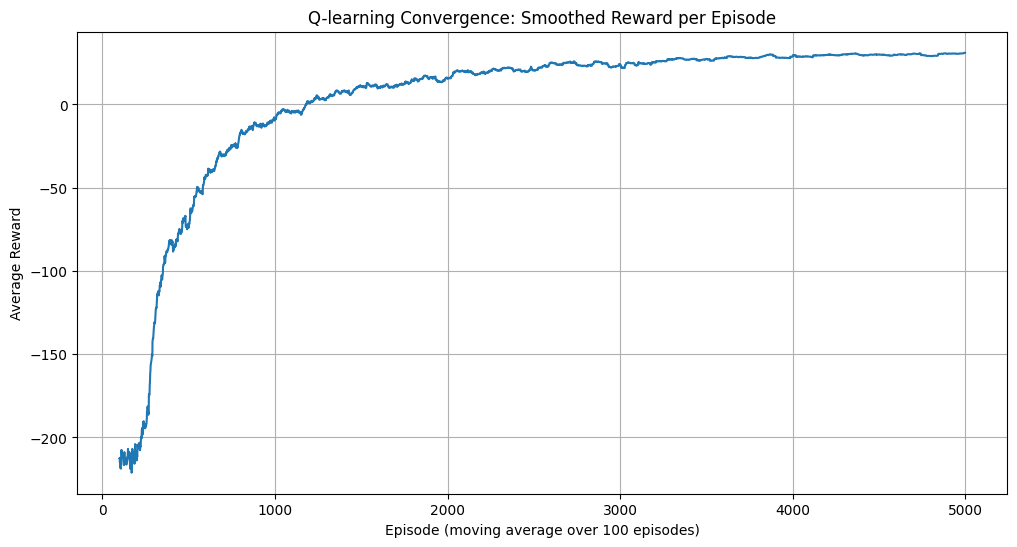

In [5]:
# Part C: Report learning curves [cite: 39]
# ---
# To make the curve smoother, we can plot a moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

window = 100
smoothed_rewards = moving_average(episode_rewards, window)

plt.figure(figsize=(12, 6))
plt.plot(range(window-1, len(episode_rewards)), smoothed_rewards)
plt.title('Q-learning Convergence: Smoothed Reward per Episode')
plt.xlabel(f'Episode (moving average over {window} episodes)')
plt.ylabel('Average Reward')
plt.grid(True)
plt.show()

In [6]:
# Part D: Policy Evaluation & Comparison [cite: 41]
# ---
def evaluate_policy(policy_q_table, num_episodes=100):
    total_rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            # Use the greedy policy (no exploration) [cite: 42]
            action = np.argmax(policy_q_table[state])
            state, reward, done = env.step(action)
            episode_reward += reward
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)

def evaluate_random_policy(num_episodes=100):
    total_rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action = np.random.choice(len(env.actions)) # Random action
            state, reward, done = env.step(action)
            episode_reward += reward
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)
    
# Evaluate the learned Q-learning policy
avg_return_q_learning = evaluate_policy(q_table, num_episodes=100)
# Evaluate the baseline random policy [cite: 43]
avg_return_random = evaluate_random_policy(num_episodes=100)

print(f"Average return over 100 test episodes (Q-learning Policy): {avg_return_q_learning:.2f}")
print(f"Average return over 100 test episodes (Random Policy):    {avg_return_random:.2f}")

Average return over 100 test episodes (Q-learning Policy): 32.38
Average return over 100 test episodes (Random Policy):    -249.61


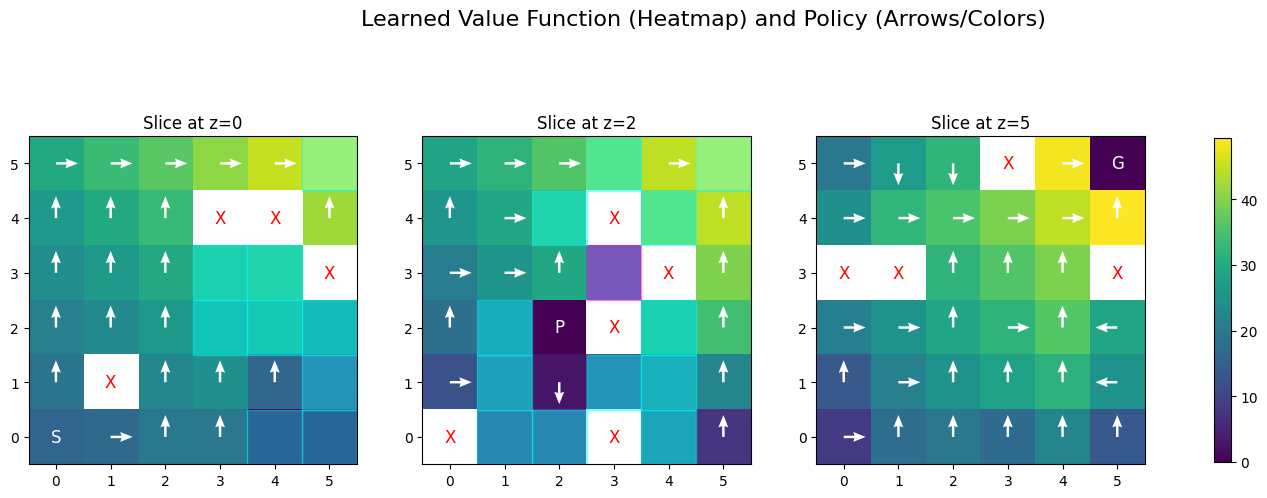

In [7]:
# Part F: Visualization [cite: 48]
# ---
# We'll visualize three z-level slices: z=0 (start level), z=2 (pit level), z=5 (goal level)
z_levels_to_plot = [0, 2, 5]

# Extract value function V(s) = max_a Q(s,a) and policy pi(s) = argmax_a Q(s,a)
value_func = {s: np.max(q) for s, q in q_table.items()}
policy = {s: np.argmax(q) for s, q in q_table.items()}

# Action direction mapping for arrows (quiver plot)
action_arrows = {
    0: (1, 0), 1: (-1, 0), # East, West (change in x, y)
    2: (0, 1), 3: (0, -1)  # North, South
    # We ignore Up/Down for the 2D plot, but will color cells that move vertically
}

fig, axes = plt.subplots(1, len(z_levels_to_plot), figsize=(18, 6))

for i, z in enumerate(z_levels_to_plot):
    ax = axes[i]
    # Create a 2D grid for the heatmap
    heatmap_data = np.full((env.size, env.size), np.nan)
    
    for y in range(env.size):
        for x in range(env.size):
            state = (x, y, z)
            if state in value_func:
                heatmap_data[y, x] = value_func[state]

    # Plot the heatmap of the value function [cite: 49]
    im = ax.imshow(heatmap_data, cmap='viridis', origin='lower')

    # Overlay policy arrows and special states [cite: 50]
    for y in range(env.size):
        for x in range(env.size):
            state = (x, y, z)
            if state in env.obstacles:
                ax.text(x, y, 'X', ha='center', va='center', color='red', fontsize=12)
            elif state == env.goal_pos:
                ax.text(x, y, 'G', ha='center', va='center', color='white', fontsize=12)
            elif state == env.pit_pos:
                ax.text(x, y, 'P', ha='center', va='center', color='white', fontsize=12)
            elif state == env.start_pos:
                ax.text(x, y, 'S', ha='center', va='center', color='white', fontsize=12)
            elif state in policy:
                action_idx = policy[state]
                if action_idx in action_arrows: # Plot arrows for E,W,N,S
                    dx, dy = action_arrows[action_idx]
                    ax.quiver(x, y, dx, dy, color='white', scale=15, headwidth=4)
                else: # Color cells for Up/Down actions
                    color = 'cyan' if action_idx == 4 else 'magenta' # Up=cyan, Down=magenta
                    ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1, fill=True, color=color, alpha=0.4))
    
    ax.set_title(f'Slice at z={z}')
    ax.set_xticks(np.arange(env.size))
    ax.set_yticks(np.arange(env.size))

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
plt.suptitle('Learned Value Function (Heatmap) and Policy (Arrows/Colors)', fontsize=16)
plt.show()

Path length: 17 steps
Path followed: [(0, 0, 0), (0, 1, 0), (0, 2, 0), (0, 3, 0), (0, 4, 0), (0, 5, 0), (1, 5, 0), (2, 5, 0), (3, 5, 0), (4, 5, 0), (5, 5, 0), (5, 5, 1), (5, 5, 1), (5, 5, 2), (5, 5, 2), (5, 5, 3), (5, 5, 4), (5, 5, 5)]


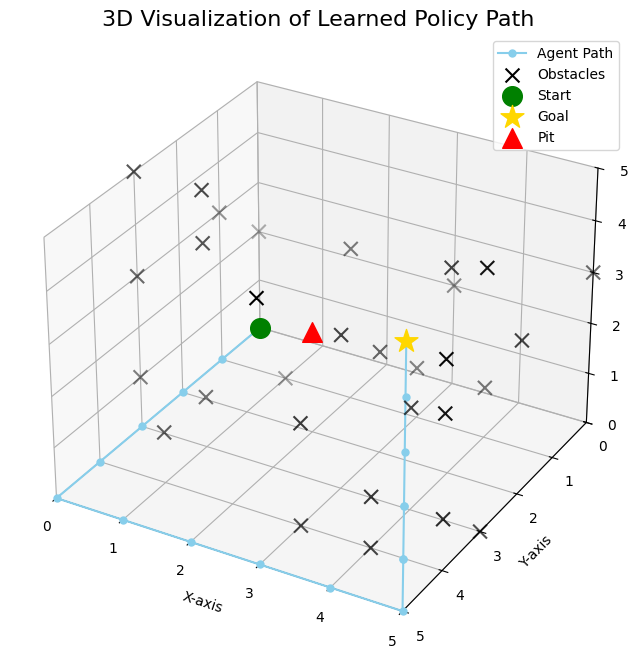

In [8]:
# Import the 3D plotting toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

# --- Step 1: Simulate one episode to get a path ---
path = []
state = env.reset()
path.append(state)
done = False

# Run a full episode using the learned greedy policy
while not done:
    action = np.argmax(q_table[state])
    state, reward, done = env.step(action)
    path.append(state)

print(f"Path length: {len(path)-1} steps")
print(f"Path followed: {path}")

# --- Step 2: Prepare the data for plotting ---
# Unzip the path coordinates into separate lists for x, y, and z
path_x, path_y, path_z = zip(*path)
# Unzip obstacle coordinates
obs_x, obs_y, obs_z = zip(*env.obstacles) if env.obstacles else ([], [], [])

# --- Step 3: Create the 3D plot ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the path the agent took
ax.plot(path_x, path_y, path_z, '-o', c='skyblue', markersize=5, label='Agent Path')

# Plot obstacles, start, goal, and pit states
ax.scatter(obs_x, obs_y, obs_z, c='black', marker='x', s=100, label='Obstacles')
ax.scatter(*env.start_pos, c='green', marker='o', s=200, label='Start')
ax.scatter(*env.goal_pos, c='gold', marker='*', s=300, label='Goal')
ax.scatter(*env.pit_pos, c='red', marker='^', s=200, label='Pit')

# --- Step 4: Formatting the plot ---
ax.set_title('3D Visualization of Learned Policy Path', fontsize=16)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set the axis limits to match the grid dimensions
ax.set_xlim([0, env.size-1])
ax.set_ylim([0, env.size-1])
ax.set_zlim([0, env.size-1])

# Invert Y-axis to match the 2D heatmap's origin
ax.invert_yaxis()

ax.legend()
plt.show()